In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [2]:
transform = transforms.Compose([
    #transforms.Grayscale(),
    transforms.ToTensor(),
])

traindataset = datasets.STL10('./downloads/', download=True, split='train', transform=transform)
testdataset = datasets.STL10('./downloads/', download=True, split='test', transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
bs =1000
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

torch.Size([1000, 3, 96, 96])


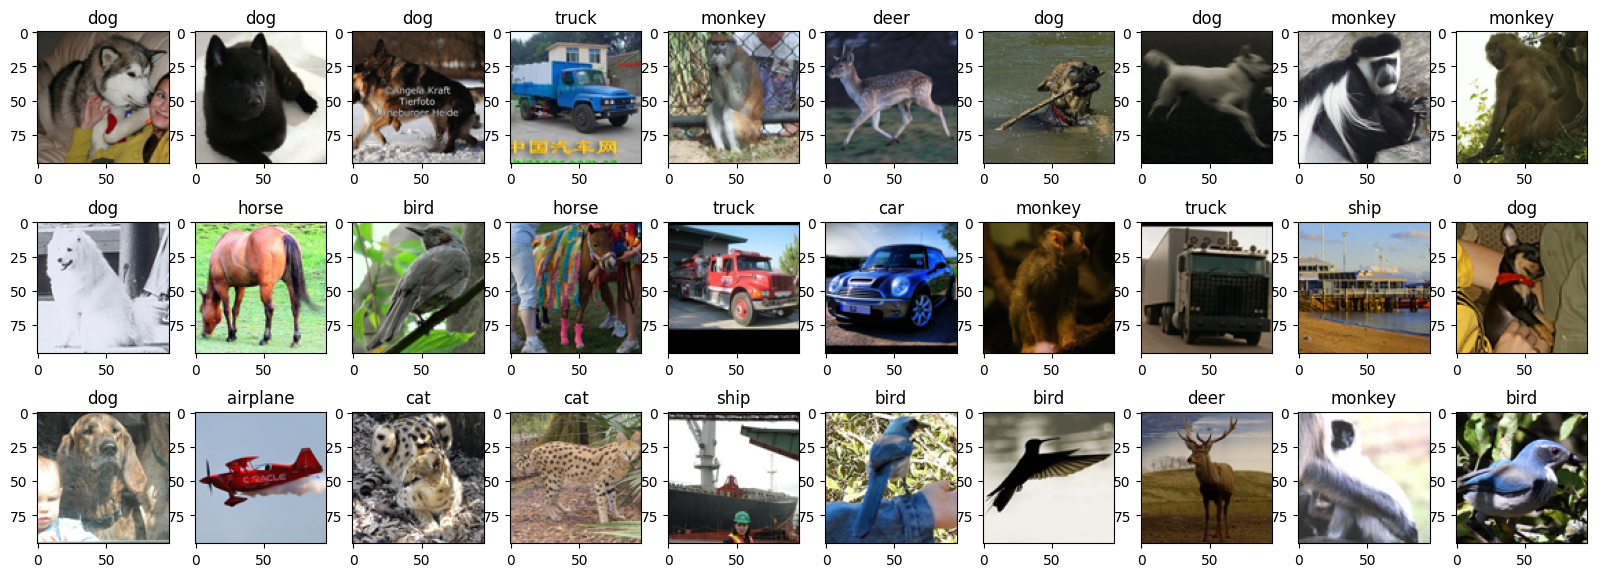

In [11]:
def view_samples():
    
    test_images, labels = next(iter(testloader))
    print(test_images.shape)
    fig = plt.figure(figsize =(20,7))
    nrows = 3
    ncols = 10
    b=np.random.randint(0,test_images.shape[0]-nrows*ncols)
    for i in range(nrows*ncols):
        inp = test_images.view(-1, 96, 96)
        plot = fig.add_subplot(nrows, ncols, i+1)
        plot.set_title(testdataset.classes[labels[i+b].cpu().numpy()])
        imgplot = plt.imshow(np.transpose(test_images[i+b], (1, 2, 0)).cpu())
    plt.show()
view_samples()

In [5]:
# Load the pre-trained ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:

# Define the optimizer and loss function

adam =  torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [8]:
# Train the model
def train_and_plot(optimizer,num_epochs = 10):
    num_epochs = 10
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        for images, labels in trainloader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()*images.size(0)
        # Evaluate the model on the validation set
        with torch.no_grad():
            for images, labels in testloader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*images.size(0)
        train_loss = train_loss/len(trainloader)
        val_loss = val_loss/len(testloader)
        print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}, \tTest Loss: {val_loss:.6f}, ')
        loss_list.append([train_loss,val_loss])
    return np.array(loss_list)


In [12]:
loss_list = train_and_plot(adam)

Epoch: 1 	Training Loss: 61.776686, 	Test Loss: 408.448793, 
Epoch: 2 	Training Loss: 18.052145, 	Test Loss: 444.614679, 
Epoch: 3 	Training Loss: 7.650427, 	Test Loss: 466.596145, 
Epoch: 4 	Training Loss: 2.313766, 	Test Loss: 488.176264, 
Epoch: 5 	Training Loss: 1.438359, 	Test Loss: 505.227964, 
Epoch: 6 	Training Loss: 0.771018, 	Test Loss: 514.429480, 
Epoch: 7 	Training Loss: 0.526526, 	Test Loss: 517.619975, 
Epoch: 8 	Training Loss: 0.391191, 	Test Loss: 518.151004, 
Epoch: 9 	Training Loss: 0.289701, 	Test Loss: 517.412305, 
Epoch: 10 	Training Loss: 0.235234, 	Test Loss: 516.256694, 


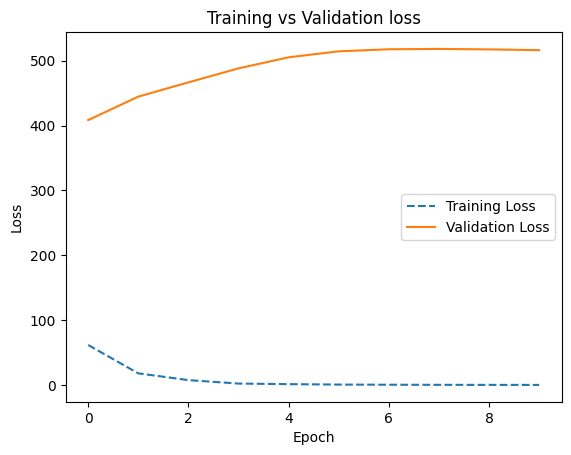

In [13]:
plt.title("Training vs Validation loss")
plt.plot(loss_list[:,0], linestyle='--', label="Training Loss")
plt.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
test_images, test_labels = next(iter(testloader))
test_output = model(test_images)

In [16]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred, label):
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = np.trace(cm)/sum(cm.flatten())

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    plt.figure(figsize=(10, 10))
    plt.title('Accuracy Score: {0:3.3f}'.format(overallAccuracy), size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print('Overall Accuracy Score: {0:3.3f}'.format(overallAccuracy))
    print('Classwise Accuracy Score: {0}'.format(classwiseAccuracy))

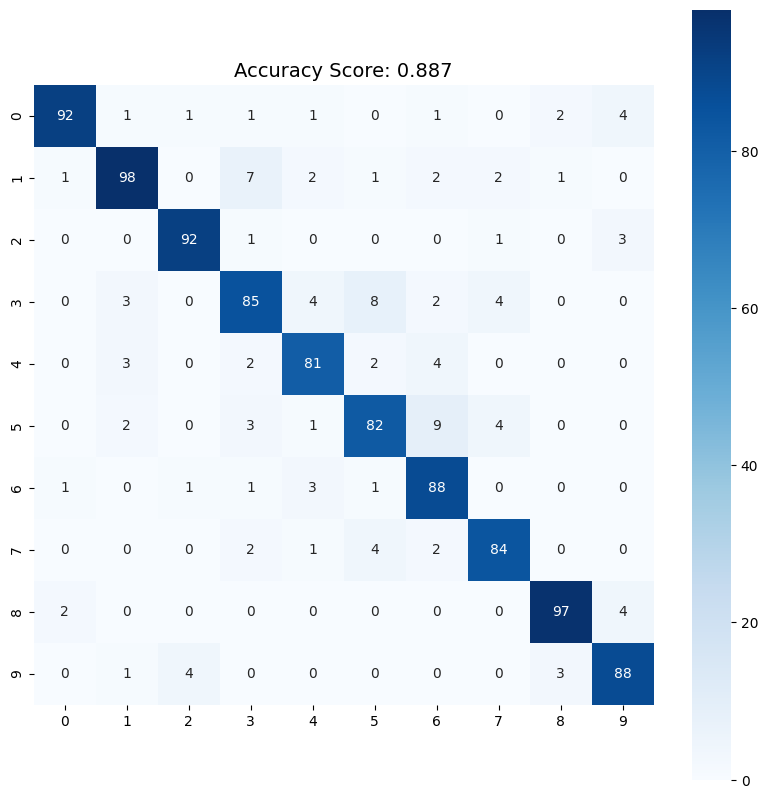

Overall Accuracy Score: 0.887
Classwise Accuracy Score: [0.89320388 0.85964912 0.94845361 0.80188679 0.88043478 0.81188119
 0.92631579 0.90322581 0.94174757 0.91666667]


In [18]:
with torch.no_grad():
    confusionMatrixAndAccuracyReport(test_labels,test_output.argmax(axis=1),testdataset.classes)